## SigNET implementation on CEDAR Signature Dataset

In this notebook we are going to implement a Siamese Network to predict if a signature is original or forged.

This is an implementation of the paper "SigNet: Convolutional Siamese Network for Writer Independent Online Signature
Verification".

So, without any further delay lets move on to importing the necessary packages.

In [1]:
## Importing the necessary packages ##

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import transforms
import torch.nn.functional as F

import os
from tqdm import tqdm
import PIL
import numpy as np
import matplotlib.pyplot as plt

**Disclaimer:** Please don't get overwhelmed by all the imports since I prefer to come back up and import the packages in the first cell.

The most important things to look for in this project are the following.

- [X] Creation of the dataset, where each time data is passed into the model, an original signature of a person should be present and along with it another original signature or a forged signature of the same person needs to be there. If both the signatures are original the output value should try to be 1, while if the pair is an original and a forged one it should be 0.
- [X] Siamese (Twin) Network Architecture as devised by the paper we are trying to implement.
- [X] The contrastive loss function which emphasises the distance between the extracted feature maps -- larger for contrastive signatures and smaller for similar ones. 

So, let's carry on and bring in our dataset, which is the first step in this project.

So, lets head over to that.

In [2]:
## Making custom dataset class ##

class SigDataset(Dataset):
    
    def __init__(self , original_path , forge_path):
        
        # Setting the original and forge paths #
        
        self.original_path = original_path 
        self.forge_path = forge_path
        
        self.original_path_list = os.listdir(original_path) # necessary for finding the dataset length
        
    def __getitem__(self , idx):
        
        person_id = int(idx % 55) + 1 #since total number of authors are 55

        sample = int(np.random.randint(low = 1 , high = 25 , size = 1)) # for Randomly picking a signature 
        
        org_img_name = 'original_'+ str(person_id) + '_' + str(sample) + '.png' #original signature image name
        
        org_img_path = os.path.join(self.original_path , org_img_name)
        
        org_img = PIL.Image.open(org_img_path).convert('RGB') # Inputing the image using PIL
        
        inv_org_img = PIL.ImageOps.invert(org_img) #Inverting the image
        
        aug = transforms.Compose([
            transforms.Resize((155 , 220)),
            transforms.ToTensor()
        ]) # Data augmentations 
        
        org_tensor = aug(inv_org_img)
        
        
        label = int(np.random.randint(low = 0 , high = 2 , size = 1)) # selecting the second image.
                                                                      # if 1 pick one original image.
                                                                      # if 0 pick a forged image.
        
        
        
        if label == 0:
            
            # Picking forged image #
            sample1 = int(np.random.randint(low = 1 , high = 25 , size = 1))
            
            forg_img_name = 'forgeries_'+ str(person_id) + '_' + str(sample1) + '.png'
            
            forg_img_path = os.path.join(self.forge_path , forg_img_name)
            
            forg_img = PIL.Image.open(forg_img_path).convert('RGB')
        
            inv_forg_img = PIL.ImageOps.invert(forg_img)
            
            forg_tensor = aug(inv_forg_img)
            
            return org_tensor , forg_tensor , label
            
            
        else:
            # Picking real image #
            
            sample2 = int(np.random.randint(low = 1 , high = 25 , size = 1))
            
            sim_img_name = 'original_'+ str(person_id) + '_' + str(sample2) + '.png'
            
            sim_img_path = os.path.join(self.original_path , sim_img_name)
            
            sim_img = PIL.Image.open(sim_img_path).convert('RGB')
        
            inv_sim_img = PIL.ImageOps.invert(sim_img)
            
            sim_tensor = aug(inv_sim_img)
            
            return org_tensor , sim_tensor , label
        
    def __len__(self):
            
        return len(self.original_path_list)

This looks humungous I know. But needed to do this.

Okay lets carry on and check if we have done things correctly.

In [3]:
## Setting our dataset object ##

signature_data = SigDataset('../input/signature-dataset/signatures/full_org' , 
                            '../input/signature-dataset/signatures/full_forg')

print('Length of the dataset is :' , len(signature_data))

Length of the dataset is : 1321


Yeps!

That should have the number of images in our folder.

Now lets visualize.

Label : 0
Original Image
Shape : torch.Size([3, 155, 220])


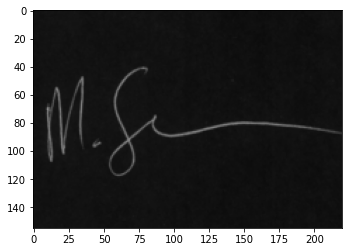

Comparative Image
Shape : torch.Size([3, 155, 220])


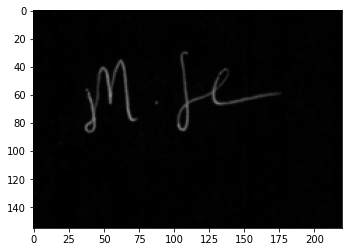

In [4]:
## Visualizing one image ##

random_idx = int(np.random.randint(low = 0 , high = len(signature_data) , size = 1))

orig_img , comp_img , label = signature_data[random_idx]

print('Label :' , label)

print('Original Image')
print('Shape :' , orig_img.shape)
plt.imshow(orig_img.permute(1 , 2 , 0))
plt.show()

print('Comparative Image')
print('Shape :' , comp_img.shape)
plt.imshow(comp_img.permute(1 , 2 , 0))
plt.show()

Even though the dataset is quite small, it is always better to utilize mini-batches of data for faster optimization. As such, we need to load the data to the model in small small batches. So, in the next section we are going to formulate that by utilizing the DataLoader.

In [5]:
## Defining the dataloader ##

signature_dataloader = DataLoader(dataset = signature_data,
                                  batch_size = 64 , 
                                  shuffle = True)

print('Dataloader size =' , len(signature_dataloader))

Dataloader size = 21


As always lets visualize a set of images.

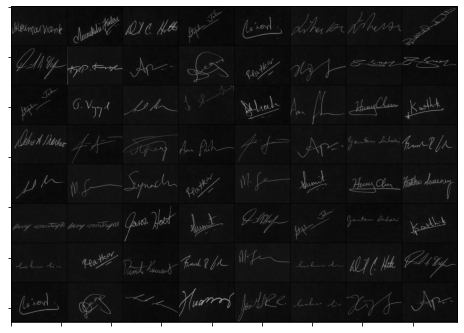

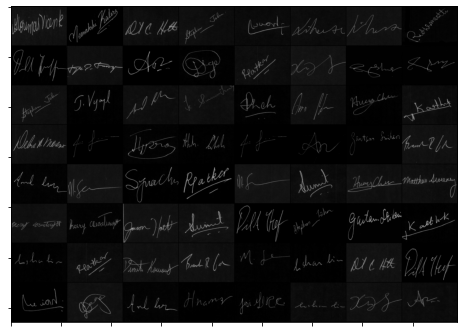

In [6]:
## Visualization ##

for org_img , comp_img , label in signature_dataloader:
    
    # Visualizing original images #
    
    fig , ax = plt.subplots(figsize = (8 , 8))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.imshow(make_grid(org_img , 8).permute(1 , 2 , 0))
    plt.show()
    
    # Visualizing Comparative images #
    
    fig , ax = plt.subplots(figsize = (8 , 8))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.imshow(make_grid(comp_img , 8).permute(1 , 2 , 0))
    plt.show()
    
    break

Yes.

We have implemented correctly.

Visualizing the previous images were not mandatory but to be confident about the implementation I prefer to visualize them.

Next up we are going to improve our dataloader such that whenever it is called, it yields a batch of data and transfer it to the GPU.

In [7]:
## Setting up GPU Dataloader ##

## First need to implement some utility functions ##

# Return device utility function #

def get_device():
    
    if torch.cuda.is_available():
        
        return torch.device('cuda')
    
    else:
        
        return torch.device('cpu')
    
# Setting the device #
device = get_device()

# Transferring data to specified device utility function #

def transfer_data(data , device):
    
    if isinstance(data , (list , tuple)):
        
        return [transfer_data(each_data , device) for each_data in data]
    
    else:
        
        return data.to(device)
    
## Finally instantiating GPU Dataloader ##

class GPUDataloader:
    
    def __init__(self , data , device):
        
        self.data = data
        
        self.device = device
        
    def __iter__(self):
        
        for batch in self.data:
            
            yield transfer_data(batch , self.device)
            
    def __len__(self):
        
        return len(self.data)

With all the functions defined its time to get our GPPU Dataloader object set up.

In [8]:
## Making our GPU Dataloader object ##

signature_dl = GPUDataloader(signature_dataloader , device)

print('Successfully Loaded!')
print('The Dataloader length is :' , len(signature_dl))

Successfully Loaded!
The Dataloader length is : 21


As always we are going to visualize a batch of images, to be certain about our implementation.

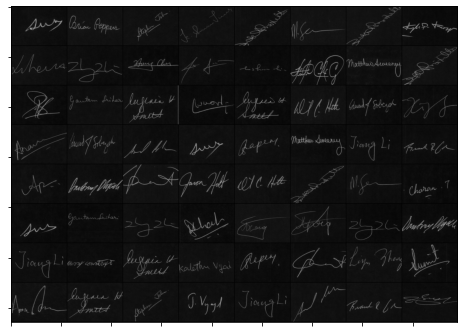

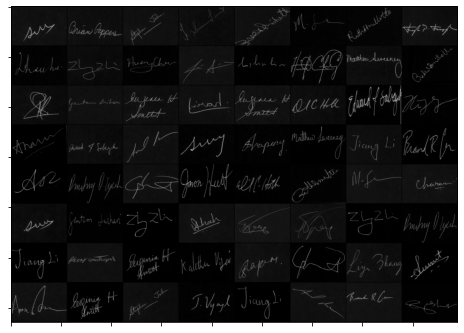

In [9]:
## Visualizing a batch of images ##

for org_img , comp_img , label in signature_dl:
    
    # Visualizing original images #
    
    fig , ax = plt.subplots(figsize = (8 , 8))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.imshow(make_grid(org_img.to('cpu') , 8).permute(1 , 2 , 0))
    plt.show()
    
    # Visualizing Comparative images #
    
    fig , ax = plt.subplots(figsize = (8 , 8))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.imshow(make_grid(comp_img.to('cpu') , 8).permute(1 , 2 , 0))
    plt.show()
    
    break

Voila! Its perfect!

Now lets move on and construct our model.

Its going to be very similar to the one given in the paper but with one single change. I will implement this network with Batch Normalization instead of Local Response Normalization.

In [10]:
## Defining our model ##

class SigNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        ## img start --> 155 * 220 ##
        
        self.network = nn.Sequential(nn.Conv2d(in_channels = 3 , out_channels = 96 , kernel_size = 11 , 
                                               stride = 1 , padding = 0 ,bias = False), # 96 * 145 * 210 #
                                     nn.ReLU(),
                                     nn.BatchNorm2d(num_features = 96), 
                                     nn.MaxPool2d(kernel_size = 3 , stride = 2), # 96 * 72 * 104 #
                                     nn.Conv2d(in_channels = 96 , out_channels = 256 , kernel_size = 5 , 
                                               stride = 1 , padding = 2 , bias = False),  # 256 * 72 * 104 #
                                     nn.ReLU(),
                                     nn.BatchNorm2d(num_features = 256),
                                     nn.MaxPool2d(kernel_size = 3 , stride = 2), # 256 * 35 * 51 #
                                     nn.Dropout(p = 0.3),
                                     nn.Conv2d(in_channels = 256 , out_channels = 384 , kernel_size = 3 , 
                                               stride = 1 , padding = 1 , bias = True), # 384 * 35 * 51 #
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels = 384 , out_channels = 256 , kernel_size = 3 , 
                                               stride = 1 , padding = 1 , bias = True), # 256 * 35 * 51 #
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size = 3 , stride = 2), # 256 * 17 * 25 #
                                     nn.Dropout(p = 0.3),
                                     nn.Flatten(),
                                     nn.Linear(256*17*25 , 1024),
                                     nn.Linear(1024 , 128))
        
    def forward(self , inp_1 , inp_2):
        
        out_1 = self.network(inp_1)
        
        out_2 = self.network(inp_2)
        
        return out_1 , out_2

With model all set.

Lets instantiate two models of the same network.

In [11]:
## Siamese models ##

siamese_net = SigNet().to(device)

And its done.

Now in this notebook we will implement xavier initialization.

So, in the next step lets do that.

In [12]:
## Initialization of weights ##

def initialize_weights(layer):
    
    if (type(layer) == nn.Conv2d) or (type(layer) == nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        if layer.bias != None:
            torch.nn.init.uniform_(layer.bias , a = 0.0 , b = 1.0)
        
siamese_net = siamese_net.apply(initialize_weights)    

Now last thing to do is to set the contrastive loss function.

So, lets go and implement that next.

In [13]:
## Defining contrastive loss ##

class ContrastiveLoss(nn.Module):
    
    def __init__(self , margin):
        
        super().__init__()
        
        self.margin = margin
        
    def forward(self , map_1 , map_2 , label):
        
        euclidean_distance = F.pairwise_distance(map_1, map_2)
        
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive

With the loss function defined lets initialize it.

In [14]:
## Loss function ##

con_loss = ContrastiveLoss(1.0)

FInally lets set our optimizer.

In [15]:
## Optimizer ##

optimizer = torch.optim.RMSprop(siamese_net.parameters() , lr = 1e-4)

Now it time to TRAIN!

In [16]:
num_epochs = 20

loop = tqdm(range(num_epochs) , total = num_epochs)

for epoch in loop:
    
    for org_img , comp_img , label in signature_dl:
        
        optimizer.zero_grad()
        
        org_map , comp_map = siamese_net(org_img , comp_img)
        
        loss = con_loss(org_map , comp_map , label)
        
        loss.backward()
        
        optimizer.step()
        
    loop.set_description('Epochs : {} / {}'.format(epoch + 1 , num_epochs))
    loop.set_postfix(loss = loss.item())

Epochs : 20 / 20: 100%|██████████| 20/20 [05:26<00:00, 16.31s/it, loss=0.469]


Amazing. The training is done! We achieved very low loss :)

Lets save our model.

In [17]:
torch.save(siamese_net , 'sig_net.pth')